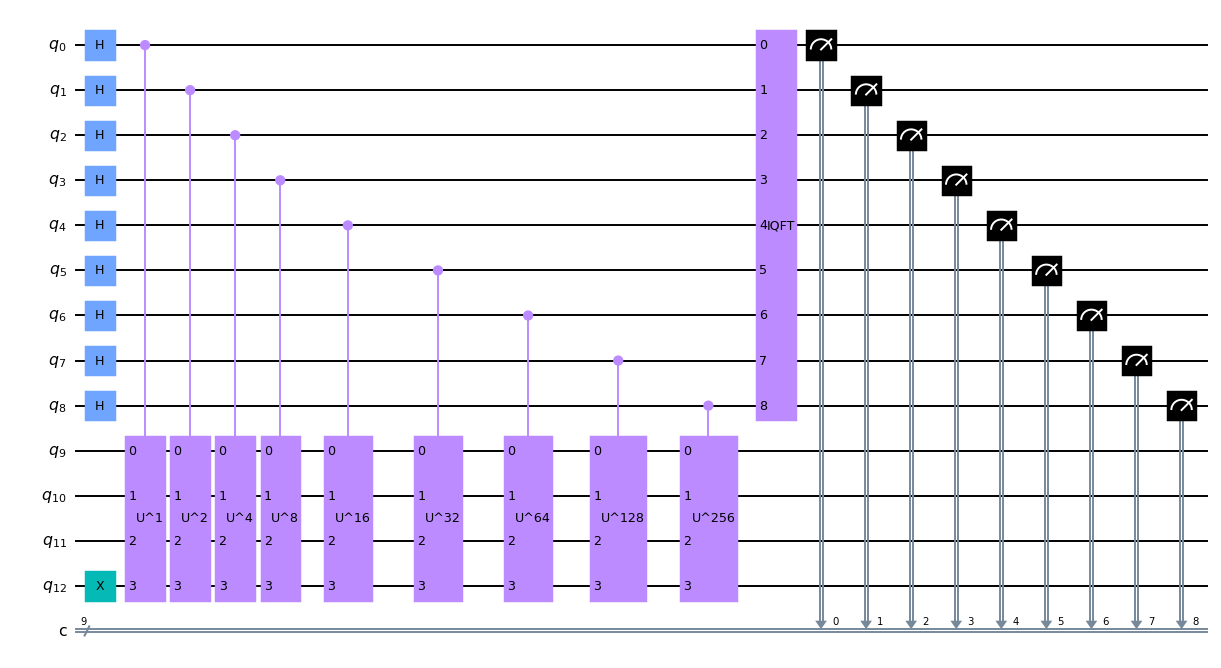

In [57]:
import math
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.visualization import plot_histogram, circuit_drawer

from math import gcd
from fractions import Fraction

# Constants
N = 15
x = 7
n_count = 9  # number of counting qubits

# Controlled Unitary Operation
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{'U'}^{power}"
    c_U = U.control()
    return c_U

# Inverse Quantum Fourier Transform
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "IQFT"
    return qc


# Quantum Phase Estimation Circuit
qc = QuantumCircuit(n_count + 4, n_count)
qc.x(3 + n_count)
for q in range(n_count):
    qc.h(q)
for q in range(n_count):
    qc.append(c_amod15(x, 2**q), [q] + [i + n_count for i in range(4)])
qc.append(qft_dagger(n_count), range(n_count))
qc.measure(range(n_count), range(n_count))

# Visualize the Circuit
circuit_drawer(qc, output='mpl', scale=0.7, fold=-1)

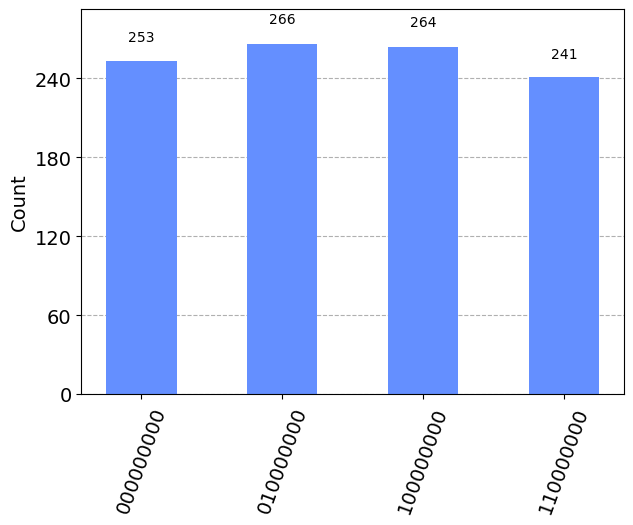

In [58]:
# Simulate the Circuit
simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc, shots=1024).result()
counts = result.get_counts(qc)

# Plot histogram
plot_histogram(counts)

In [59]:
# Determine the order r
def determine_order(counts):
    measured_str = max(counts, key=counts.get)
    measured = int(measured_str, 2)
    phase = measured / (2**n_count)
    frac = Fraction(phase).limit_denominator(N)
    return frac.denominator

r = determine_order(counts)
print(f"Order r: {r}")

Order r: 4


In [60]:
# Classical post-processing to factorize N
factor_found = False
if r % 2 == 0:
    plus = gcd(pow(x, r//2) + 1, N)
    minus = gcd(pow(x, r//2) - 1, N)
    if plus not in [1, N]:
        print(f"One factor of {N} is {plus}")
        factor_found = True
    if minus not in [1, N]:
        print(f"One factor of {N} is {minus}")
        factor_found = True

if not factor_found:
    print("No factors found. Try a different random x.")

One factor of 15 is 5
One factor of 15 is 3
